In [ ]:
# Creating virtual environment
#%pip install virtualenv
#%python3 -m venv env
#%source env/bin/activate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import sys
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
import statsmodels.api as sm 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# reading data
data = pd.read_csv("../input/NBA_Dataset.csv")

In [5]:
# view first 3 observations
data.head(3)

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0


In [6]:
# shape of the data
data.shape

(159, 7)

In [7]:
# columns in the data
data.columns

Index(['Team', 'Points_Scored', 'Weightlifting_Sessions_Average',
       'Yoga_Sessions_Average', 'Laps_Run_Per_Practice_Average',
       'Water_Intake', 'Players_Absent_For_Sessions'],
      dtype='object')

**Exploratory Data Analysis**

In [8]:
# info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


There are total 159 rows and 7 columns. Observe that there are few null values in the dataset

In [9]:
# rename the columns
df = data.rename(columns={'Points_Scored': 'Points', 'Weightlifting_Sessions_Average': 'WL', 'Yoga_Sessions_Average': 'Yoga', 'Laps_Run_Per_Practice_Average': 'Laps', 'Water_Intake': 'WI', 'Players_Absent_For_Sessions': 'PAFS'})

In [10]:
# view first 5 rows
df.head()

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


Text(0.5, 1.0, 'Distribution plot for Points')

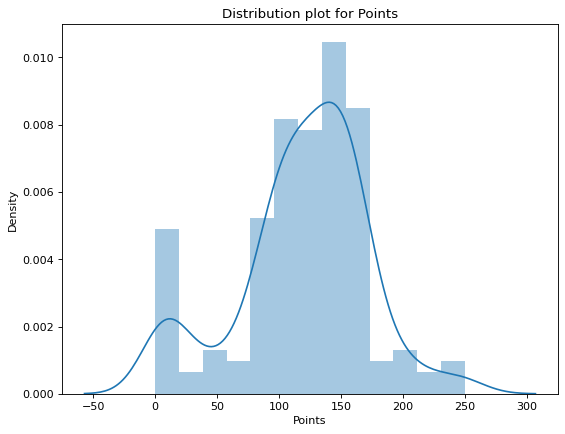

In [11]:
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(df.Points)
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Points")

Text(0.5, 1.0, 'Distribution plot for Square Root of Points')

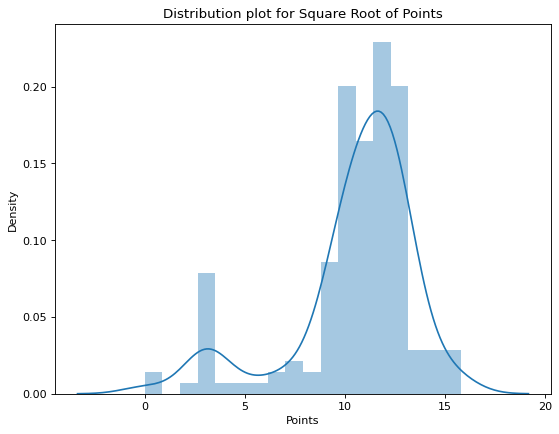

In [12]:
# The data shows some outliers. let's transform it and check
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(np.sqrt(df.Points))
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Square Root of Points")

Text(0.5, 1.0, 'Box Plot for Points')

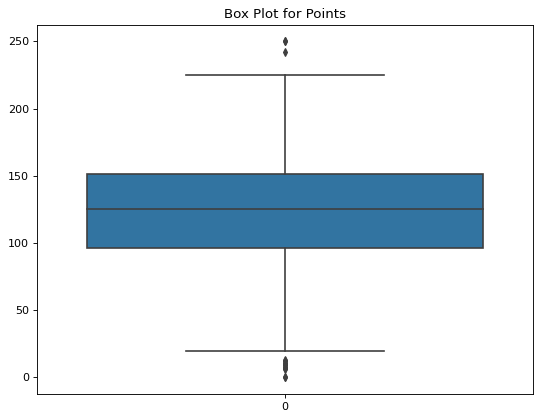

In [13]:
# Lets check the boxplot visualization of Points which tells us the outliers
figure(figsize=(8,6), dpi= 80)
sns.boxplot(df.Points)
plt.title("Box Plot for Points")

In [14]:
df.tail(100)

,Team,Points,WL,Yoga,Laps,WI,PAFS
59,Clippers,156,34.0,28.0,40.0,5.0,5.0
60,Clippers,122,37.0,29.0,44.0,5.0,2.0
61,Warriors,55,14.0,8.0,17.0,3.0,3.0
62,Warriors,60,14.0,8.0,17.0,3.0,4.0
63,Warriors,90,16.0,11.0,20.0,3.0,7.0
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,NaN
155,Bulls,13,12.0,12.0,14.0,1.0,NaN
156,Bulls,12,12.0,13.0,14.0,1.0,NaN
157,Bulls,20,13.0,14.0,15.0,1.0,6.0


In [15]:
# function for plotting violin plots to visualize the distribution and shape of the data
# plotting violin and boxplot side-by-side explains the outliers in a group
def plotting_box_violin_plots(df, x, y):
    fig, axes= plt.subplots(1,2, figsize=(18,10))
    fig.suptitle("Violin and box-plots for variable: {}".format(y))

    sns.violinplot(ax=axes[0], x=x, y=y, data=df)
    sns.boxplot(ax=axes[1], data=df[y])

    axes[0].set_title("Violin plot for variable: {}".format(y))
    axes[1].set_title("Box plot for variable: {}".format(y))




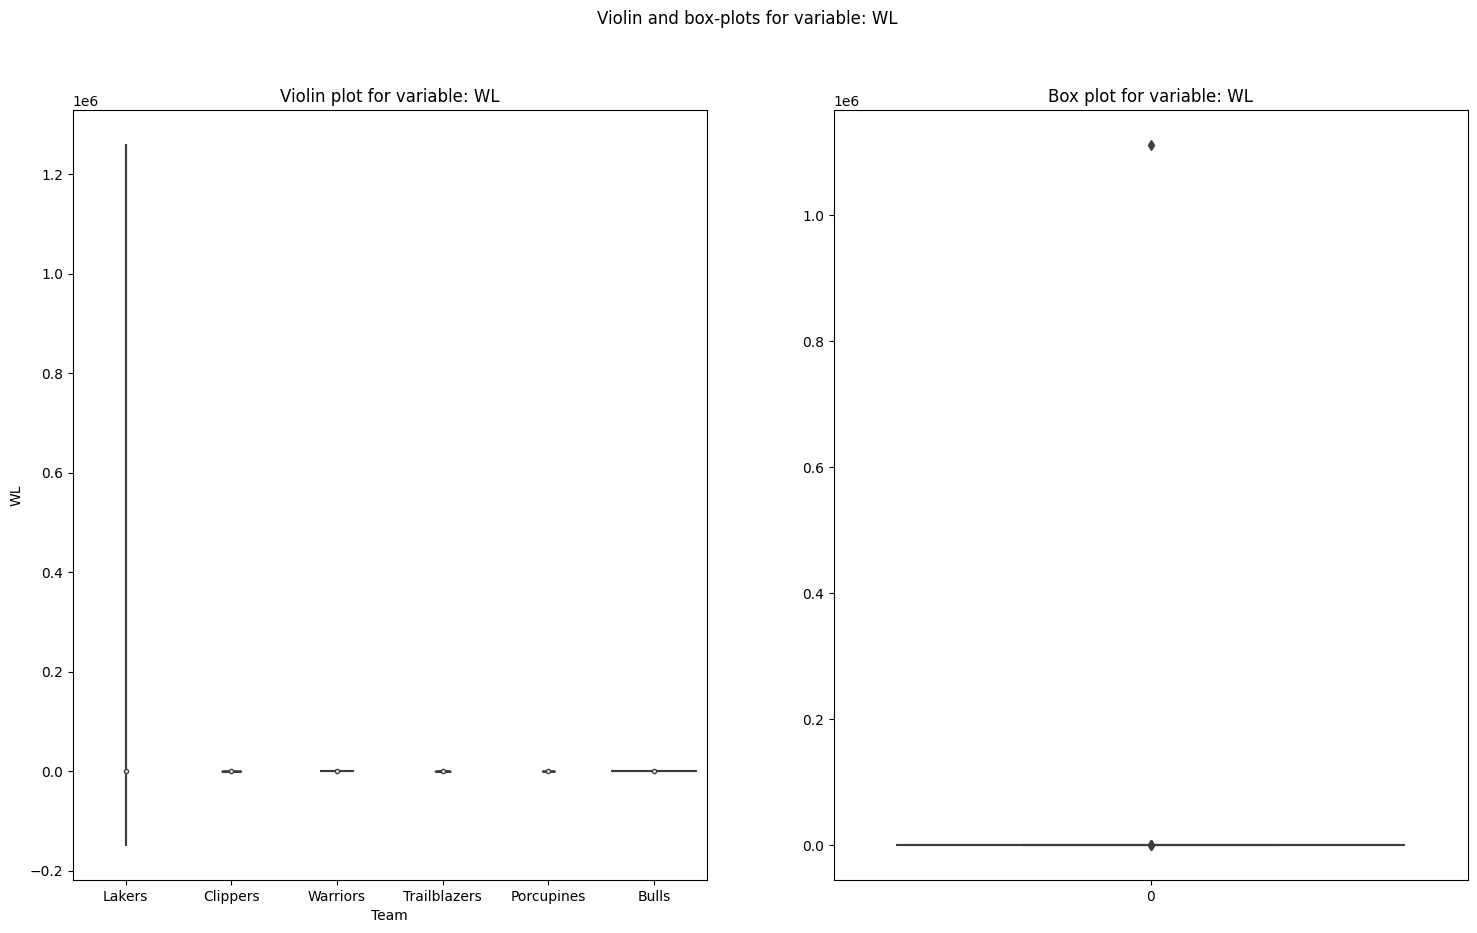

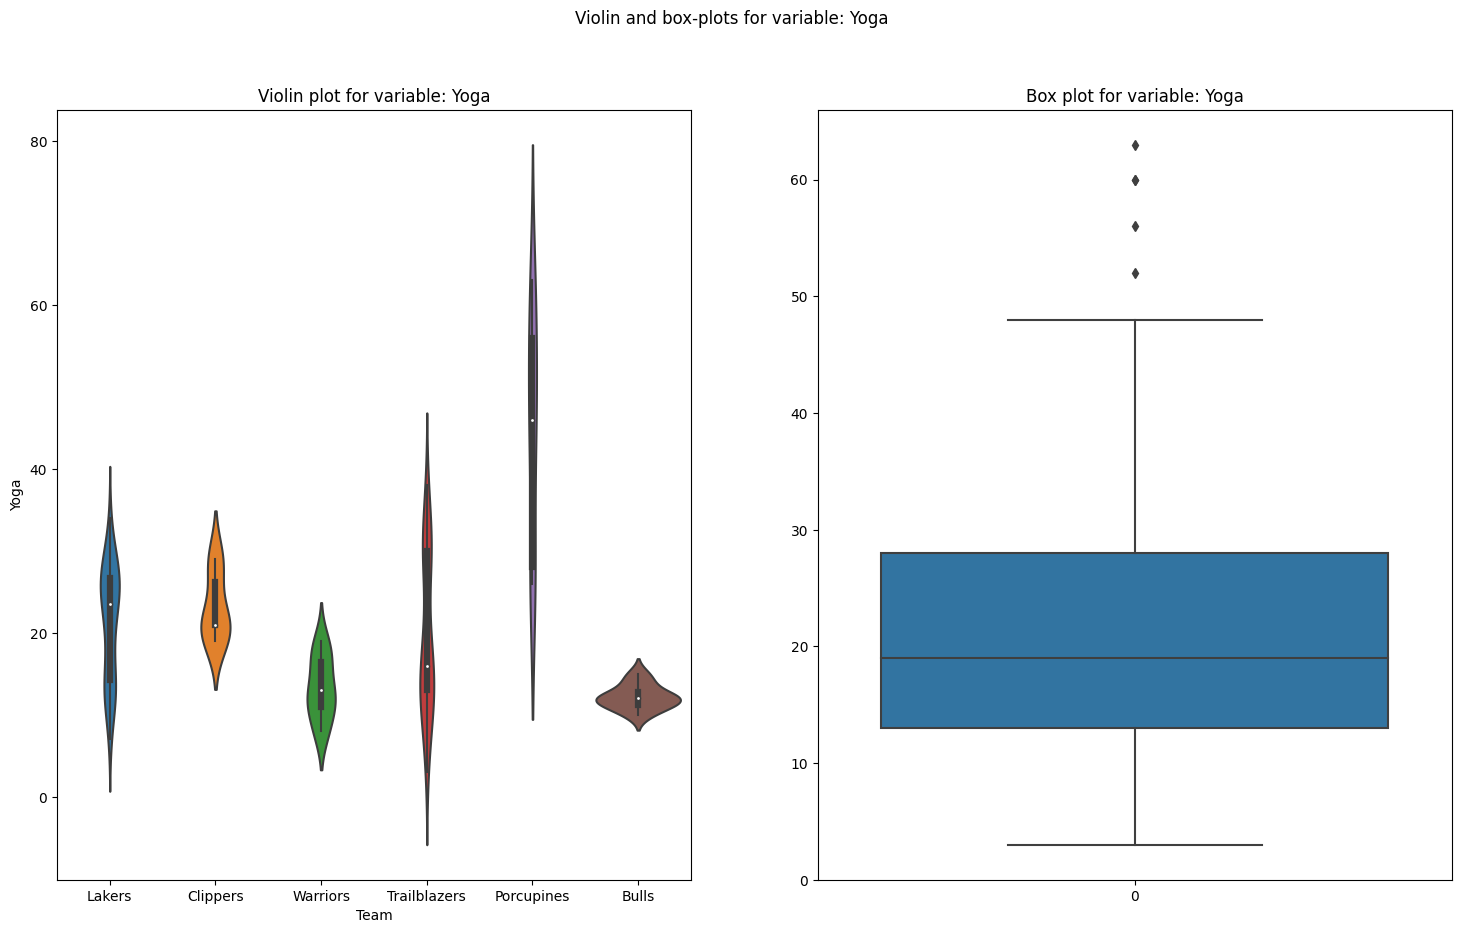

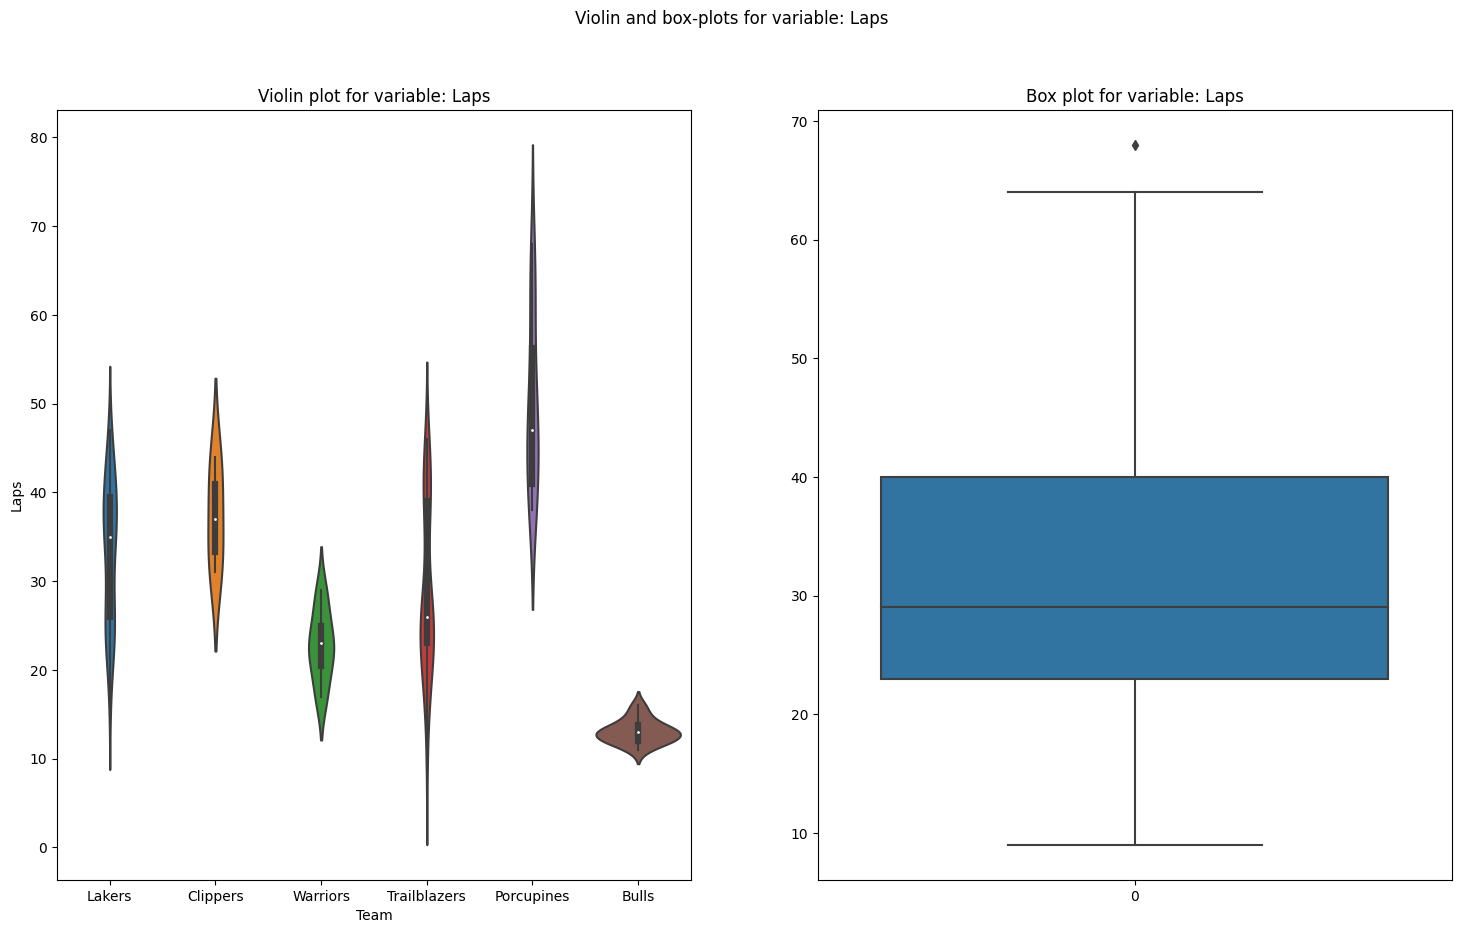

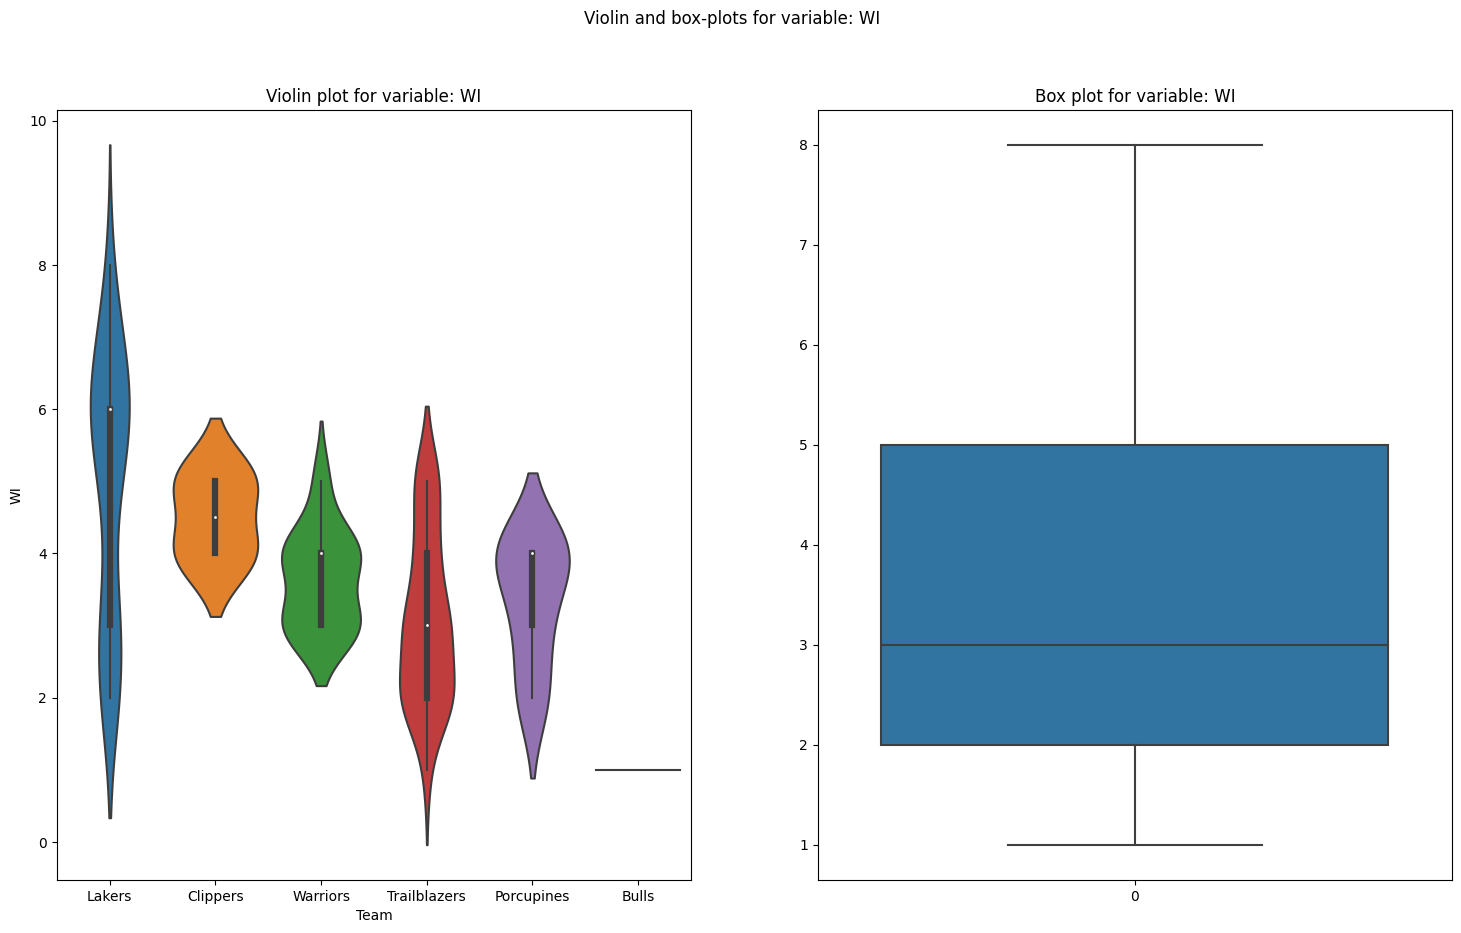

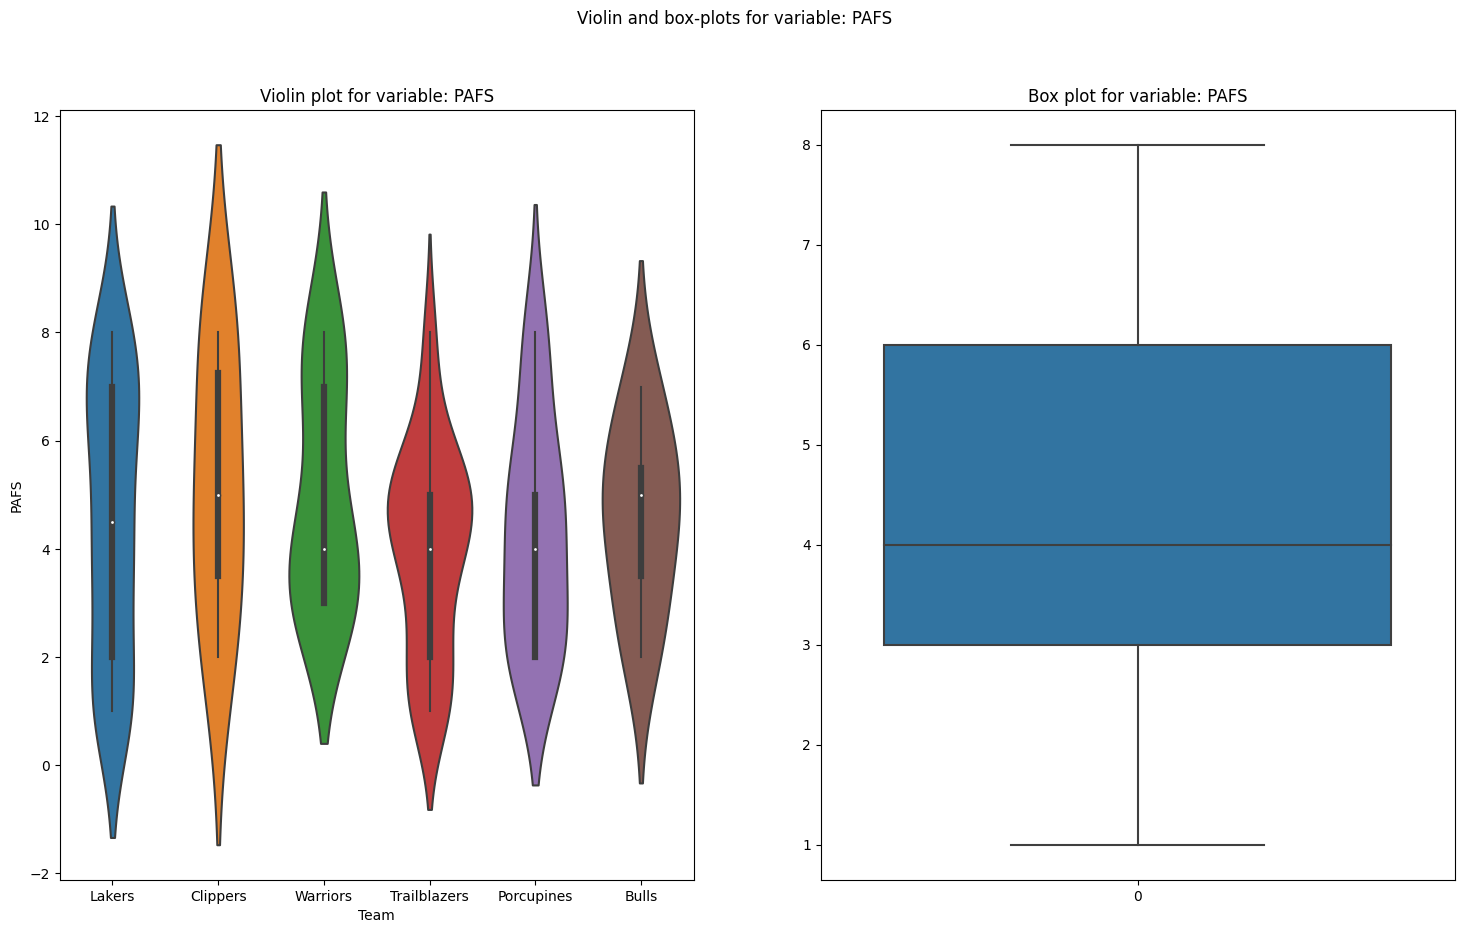

In [16]:
for x in ['WL','Yoga','Laps','WI','PAFS']:
  plotting_box_violin_plots(df,"Team",x)

**Finding Outliers using Inter Quartile Range**     
IQR is calculated as the difference between the 75th and 25th percentiles of the data, and outliers are considered to be any observations that fall below Q1-1.5(IQR) or above Q3+1.5(IQR). This method is based on the assumption that the data is approximately normally distributed

In [17]:
# function for finding out outliers
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_end = Q3 + 1.5*IQR
    lower_end = Q1 - 1.5*IQR

    outlier = df[column][(df[column]>upper_end) | (df[column]<lower_end)]

    return outlier

In [18]:
for column in ['WL','Yoga','Laps','WI','PAFS']:
    print("\n Outliers in column ", column)
    outlier = find_outliers(df, column)
    print(outlier)


 Outliers in column  WL
8      1111111.0
142         56.0
143         56.0
144         59.0
Name: WL, dtype: float64

 Outliers in column  Yoga
140    52.0
141    56.0
142    60.0
143    60.0
144    63.0
Name: Yoga, dtype: float64

 Outliers in column  Laps
144    68.0
Name: Laps, dtype: float64

 Outliers in column  WI
Series([], Name: WI, dtype: float64)

 Outliers in column  PAFS
Series([], Name: PAFS, dtype: float64)


In [19]:
# removing outliers as these rows are commonly acting as outlier in other features
df_clean = df.drop([142, 143, 144])
df_clean.shape

(156, 7)

In [20]:
# the row 8 in WL column has outlier, let's update it to NaN
df_clean['WL'][df_clean['WL'] == 1111111.0] = np.nan 
df_clean['WL'].head(10)

0    23.0
1    24.0
2    24.0
3    26.0
4    27.0
5    27.0
6    27.0
7    28.0
8     NaN
9    29.0
Name: WL, dtype: float64

In [21]:
ncounts = pd.DataFrame([df_clean.isna().mean()]).T

In [22]:
ncounts = ncounts.rename(columns={1:'data_missing'})
ncounts

,0
Team,0.000000
Points,0.000000
WL,0.064103
Yoga,0.128205
Laps,0.089744
WI,0.089744
PAFS,0.185897


<Axes: title={'center': '% of missing values across each column'}>

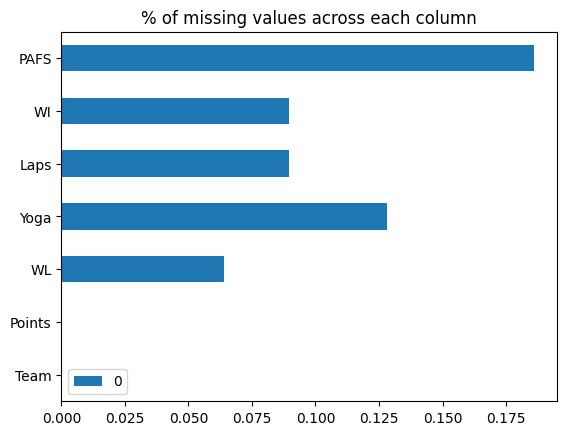

In [23]:
# plot of missing value in each column
ncounts.plot(kind= 'barh', title= '% of missing values across each column')

In [24]:
# let's compare
# if we have to remove the rows with null values, what would be the shape of our dataframe
df_clean.shape, df_clean.dropna(axis=0).shape

((156, 7), (94, 7))

In [25]:
# if we have to remove the columns with null values, what would be the shape of our dataframe
df_clean.shape, df_clean.dropna(axis=1).shape

((156, 7), (156, 2))

**Imputation Techniques**     
3 methods used here are:    
1. Pandas way -> F fill and B fill, groupby    
2. sklearn way -> imputer -> simple, iterative, knn    
3. LGBM -> to fill in the missing values

**Let's start with Pandas Imputer**

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 158
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    156 non-null    object 
 1   Points  156 non-null    int64  
 2   WL      146 non-null    float64
 3   Yoga    136 non-null    float64
 4   Laps    142 non-null    float64
 5   WI      142 non-null    float64
 6   PAFS    127 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 9.8+ KB


In [27]:
# filling missing values with -1
df_clean['WL'].fillna(-1)

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: WL, Length: 156, dtype: float64

Text(0.5, 1.0, 'Distribution Plot for WL')

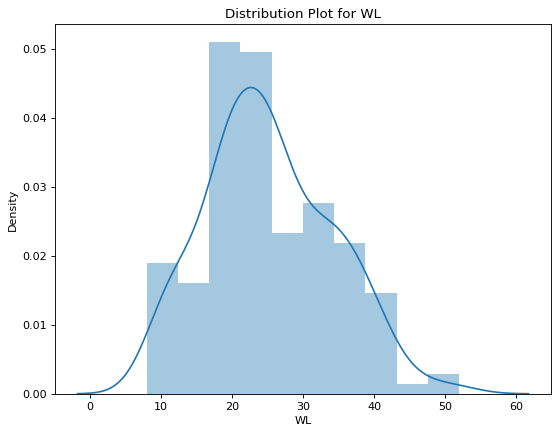

In [28]:
# visualizing after filling missing values with mean
figure(figsize=(8,6), dpi=80)
sns.distplot(df_clean['WL'].fillna(df_clean['WL'].mean()))
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution Plot for WL")

Text(0.5, 1.0, 'Distribution Plot for WL')

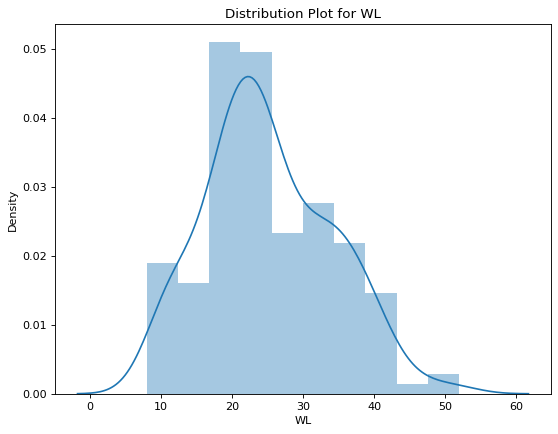

In [29]:
# visualizing after filling missing values with median
figure(figsize=(8,6), dpi=80)
sns.distplot(df_clean['WL'].fillna(df_clean['WL'].median()))
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution Plot for WL")

In [30]:
# group by team
mean_WL = df_clean.groupby("Team")['WL'].mean().to_dict()
mean_WL

{'Bulls': 11.214285714285714,
 'Clippers': 29.0,
 'Lakers': 26.04255319148936,
 'Porcupines': 39.42857142857143,
 'Trailblazers': 25.425925925925927,
 'Warriors': 18.727272727272727}

In [31]:
# replacing the null values in each group with its own mean value
WL_series = df_clean['WL'].replace(mean_WL)

Text(0.5, 1.0, 'Distribution plot WL after replacing the null with its group mean')

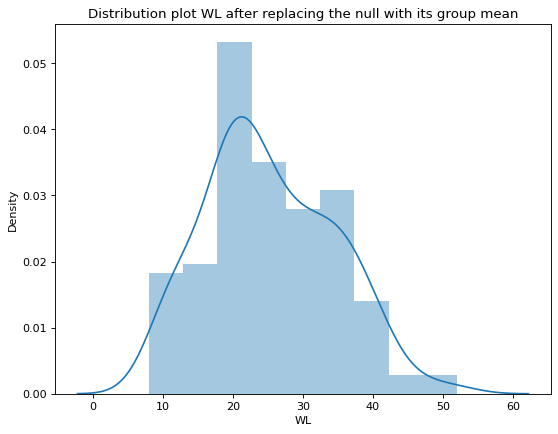

In [32]:
figure(figsize=(8,6), dpi=80)
sns.distplot(WL_series)
plt.xlabel("WL")
plt.ylabel("Density")
plt.title("Distribution plot WL after replacing the null with its group mean")

In [33]:
df_clean['WL'].replace(mean_WL)

0      23.0
1      24.0
2      24.0
3      26.0
4      27.0
       ... 
154    12.0
155    12.0
156    12.0
157    13.0
158    14.0
Name: WL, Length: 156, dtype: float64

**Sklearn Imputer**    
The main imputers provided by this module are:    
* SimpleImputer    
* IterativeImputer    
* KNN imputation

In [34]:
# 1. simple imputer
Features = ['WL','Yoga','Laps','WI','PAFS']

In [35]:
from sklearn.impute import SimpleImputer
impt = SimpleImputer(strategy='mean')

#fit and transform
si_impt = impt.fit_transform(df_clean[Features])
si_impt_df = pd.DataFrame(si_impt, columns=Features)

si_impt_df
# notice the rows where the null values are imputed

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,20.823529,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.417323
152,12.0,12.000000,14.0,1.0,4.417323
153,12.0,13.000000,14.0,1.0,4.417323
154,13.0,14.000000,15.0,1.0,6.000000


In [36]:
#2. Iterative Imputer
ITI = IterativeImputer(max_iter=10)

# fit and transform
ITI_impt = ITI.fit_transform(df_clean[Features])

ITI_impt_df = pd.DataFrame(ITI_impt, columns=Features)

ITI_impt_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,22.063002,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.413163
152,12.0,12.000000,14.0,1.0,4.413298
153,12.0,13.000000,14.0,1.0,4.413450
154,13.0,14.000000,15.0,1.0,6.000000


In [37]:
#3. KNN Imputer
from sklearn.impute import KNNImputer
KNN = KNNImputer(n_neighbors = 3)

# fit and transform
KNN_impt = KNN.fit_transform(df_clean[Features])
KNN_impt_df = pd.DataFrame(KNN_impt, columns=Features)

KNN_impt_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,22.666667,34.0,5.0,6.000000
...,...,...,...,...,...
151,12.0,12.000000,13.0,1.0,4.666667
152,12.0,12.000000,14.0,1.0,5.333333
153,12.0,13.000000,14.0,1.0,6.000000
154,13.0,14.000000,15.0,1.0,6.000000


**LGBM Imputer**     
LGBMImputer is a data imputation technique fro the python project *kuma_utils*, available at https://github.com/analokmaus/kuma_utils.git     
This is designed to fill in missing values in a dataset using gradient boosting decision trees. This technique is a variation of tree-based imputation, which uses regression trees to make predictions for missing values based on the values of other variables in the dataset.    

The LGBMImputer class takes in a dataset and a list of columns to be imputed as inputs. It then fits a LightGBM model to the data, with the target variable being the missing values and the features being the remaining variables. After training, the model is used to predict the missing values.

One advantage of LGBMImputer is that it is able to handle both categorical and numerical data, unlike some other imputation techniques that are only suitable for one or the other. Additionally, LightGBM is a fast and efficient algorithm, so LGBMImputer is able to handle large datasets with many missing values quickly.

In [68]:
# clone the repository
!git clone https://github.com/analokmaus/kuma_utils.git

Cloning into 'kuma_utils'...
remote: Enumerating objects: 971, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 971 (delta 140), reused 137 (delta 113), pack-reused 795
Receiving objects: 100% (971/971), 690.13 KiB | 4.48 MiB/s, done.
Resolving deltas: 100% (628/628), done.


In [71]:
# add to path
sys.path.append('kuma_utils/')

In [38]:
from kuma_utils.preprocessing.imputer import LGBMImputer

In [39]:
%%time
lgbm = LGBMImputer(n_iter=100, verbose=True)

#fit and transform
lgbm_itr = lgbm.fit_transform(df_clean[Features])

lgbm_itr_df = pd.DataFrame(lgbm_itr, columns=Features)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 168 ms, sys: 400 ms, total: 568 ms
Wall time: 346 ms


In [40]:
lgbm_itr_df

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.000000,30.0,5.0,4.000000
1,24.0,26.000000,31.0,5.0,8.000000
2,24.0,27.000000,31.0,5.0,7.000000
3,26.0,29.000000,34.0,5.0,1.000000
4,27.0,24.357742,34.0,5.0,6.000000
...,...,...,...,...,...
154,12.0,12.000000,13.0,1.0,3.805411
155,12.0,12.000000,14.0,1.0,3.805411
156,12.0,13.000000,14.0,1.0,3.953409
157,13.0,14.000000,15.0,1.0,6.000000


In [41]:
# let's consider this as our new dataframe which has no null values
df_new = lgbm_itr_df

**Univariate Analysis**      
This is an important step in the data exploration process, as it helps to identify any outliers, skewness, or patterns in the data that may impact further analysis or modeling.

In [42]:
df_new.columns

Index(['WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object')

<Axes: xlabel='WL', ylabel='Density'>

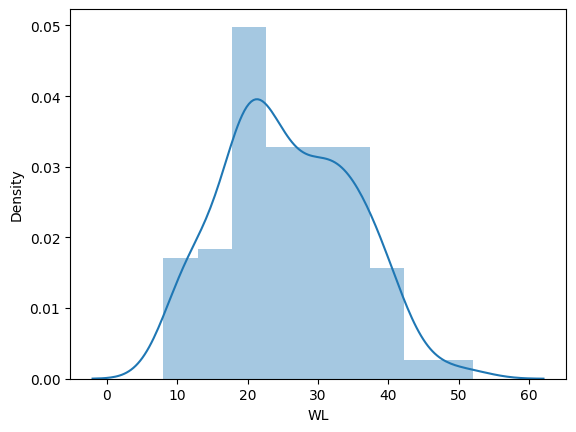

In [43]:
# distribution of WL
sns.distplot(df_new['WL'])

<Axes: xlabel='WL', ylabel='Density'>

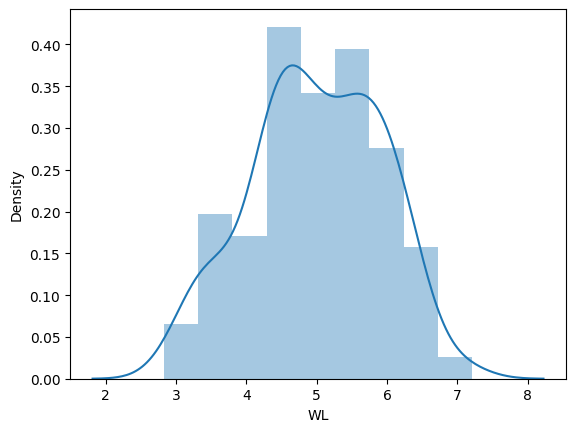

In [44]:
# let transform the WL to sqrt(WL)
sns.distplot(np.sqrt(df_new['WL']))

<Axes: >

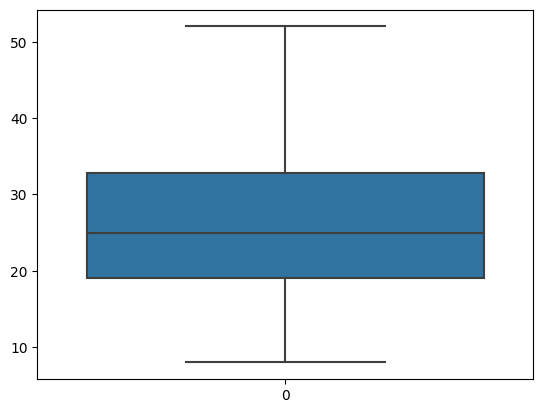

In [45]:
# boxplot of WL
sns.boxplot(df_new['WL'])

<Axes: >

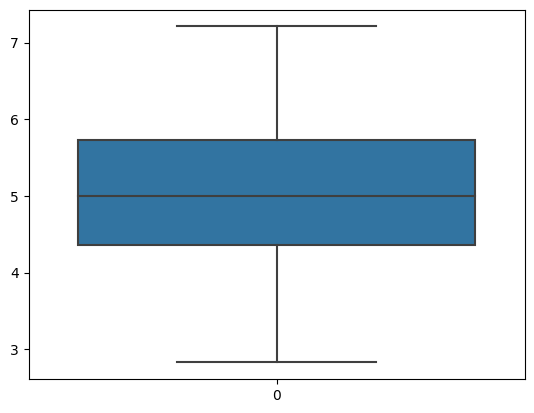

In [46]:
# boxplot of sqrt(WL)
sns.boxplot(np.sqrt(df_new["WL"]))

This transformation looks good

<Axes: >

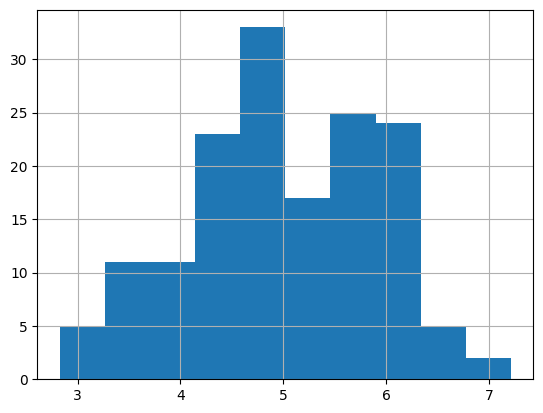

In [47]:
# histogram plot of sqrt(WL)
np.sqrt(df_new['WL']).hist()

<Axes: >

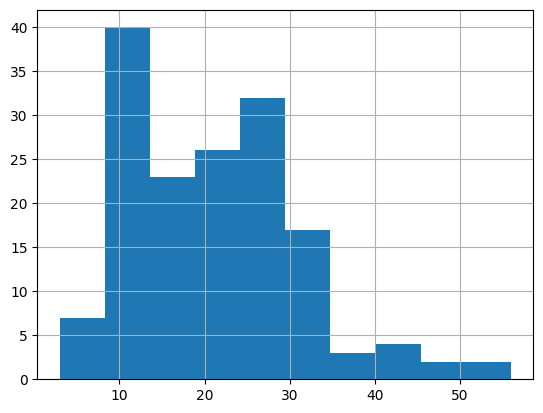

In [48]:
# let's check another imputed variable Yoga
df_new['Yoga'].hist()

<Axes: xlabel='Yoga', ylabel='Density'>

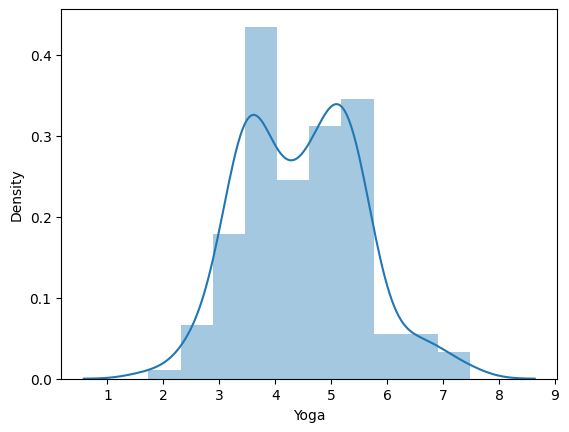

In [49]:
# distribution of sqrt(Yoga)
sns.distplot(np.sqrt(df_new['Yoga']))

<Axes: xlabel='PAFS', ylabel='Density'>

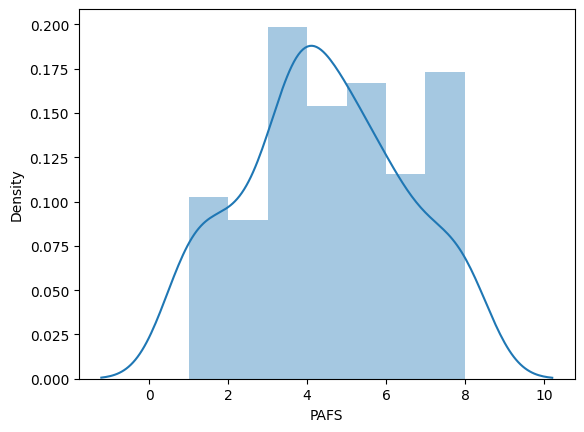

In [50]:
# distribution of PAFS
sns.distplot(df_new['PAFS'])

<Axes: xlabel='PAFS', ylabel='Density'>

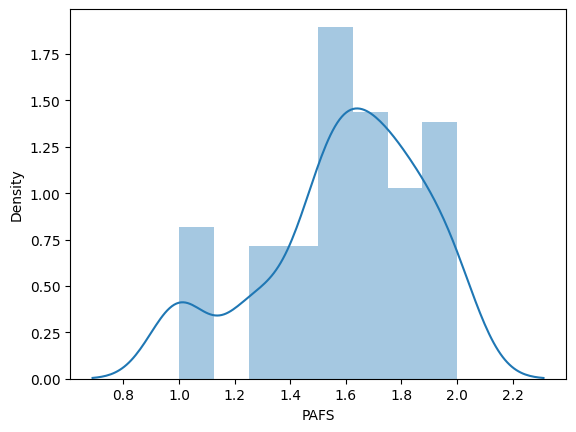

In [51]:
# distribution of cbrt(PAFS)
sns.distplot(np.cbrt(df_new['PAFS']))

**Bivariate Analysis**     
The goal here is to identify patterns and relationships in data that can be used to make predictions or draw conclusions

In [52]:
# bivariate analysis
# 1. Linear correlation -> Pearson's and Spearman's
# 2. Non linear -> Chatterjee correlations

In [53]:
df_clean.shape, df_new.shape

((156, 7), (156, 5))

In [54]:
# two columns are missing in new df
df_clean.columns, df_new.columns

(Index(['Team', 'Points', 'WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object'),
 Index(['WL', 'Yoga', 'Laps', 'WI', 'PAFS'], dtype='object'))

In [55]:
df_new['Points'] = df_clean["Points"]
df_new['Team'] = df_clean['Team']

In [56]:
df_new.head()

,WL,Yoga,Laps,WI,PAFS,Points,Team
0,23.0,25.000000,30.0,5.0,4.0,242,Lakers
1,24.0,26.000000,31.0,5.0,8.0,144,Lakers
2,24.0,27.000000,31.0,5.0,7.0,156,Lakers
3,26.0,29.000000,34.0,5.0,1.0,159,Lakers
4,27.0,24.357742,34.0,5.0,6.0,106,Lakers


In [62]:
df_new.loc[:,['WL','Yoga','Laps','WI','PAFS', 'Points']].corr()

,WL,Yoga,Laps,WI,PAFS,Points
WL,1.000000,0.940899,0.989656,0.716546,0.001012,0.448556
Yoga,0.940899,1.000000,0.927862,0.617798,0.026512,0.343593
Laps,0.989656,0.927862,1.000000,0.776036,0.024935,0.479233
WI,0.716546,0.617798,0.776036,1.000000,0.129837,0.425148
PAFS,0.001012,0.026512,0.024935,0.129837,1.000000,0.048566
Points,0.448556,0.343593,0.479233,0.425148,0.048566,1.000000


Text(0.5, 1.0, 'Linear Correlation Matrix')

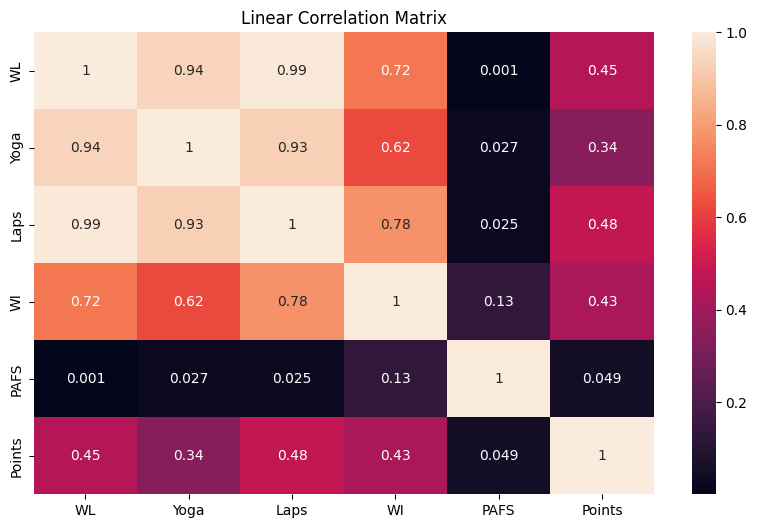

In [64]:
#heatmap of correlation matrix
plt.rcParams["figure.figsize"]=(10,6)

sns.heatmap(df_new.loc[:,['WL','Yoga','Laps','WI','PAFS', 'Points']].corr(), annot=True)
plt.title("Linear Correlation Matrix")

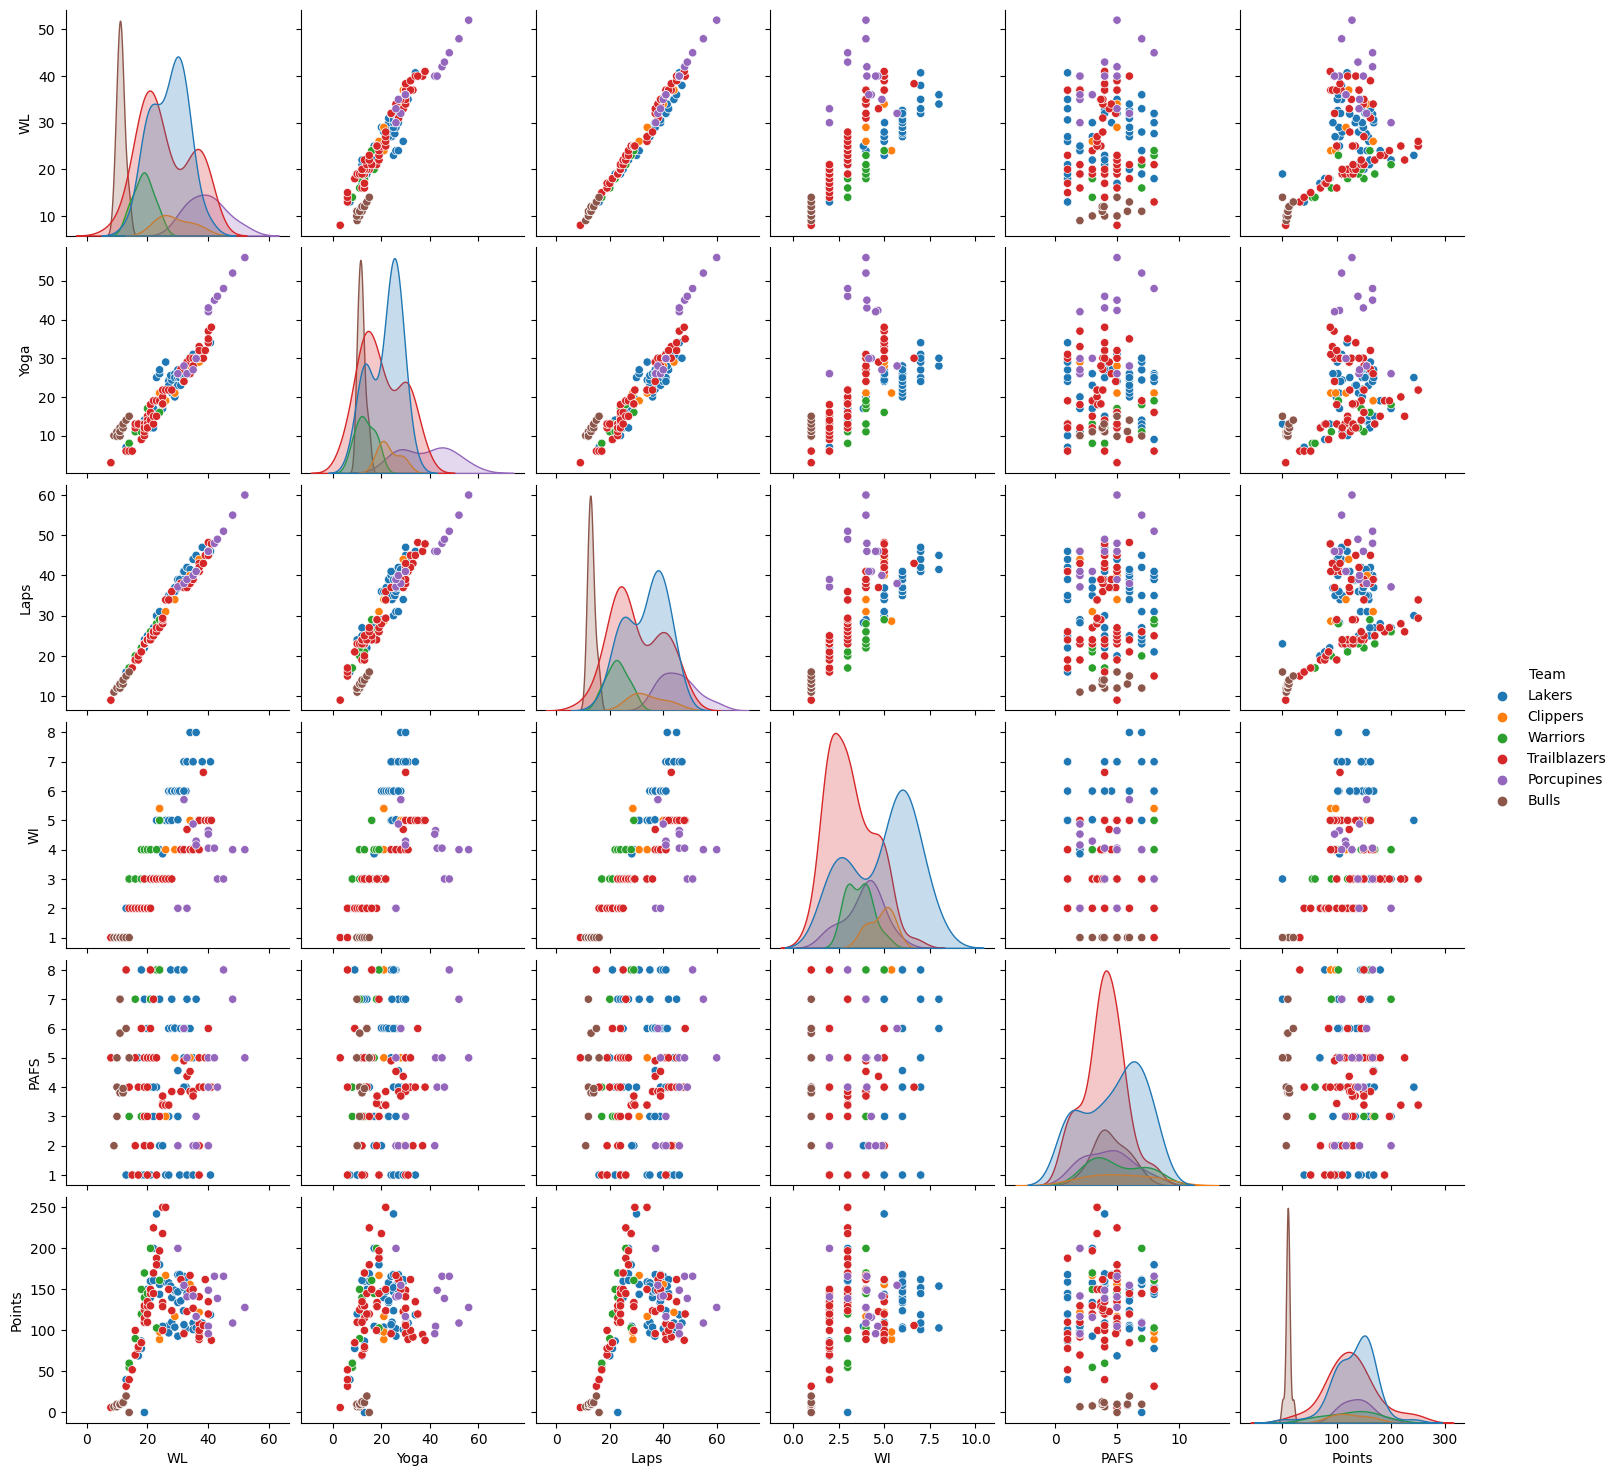

In [65]:
# pairplot of the data
sns.pairplot(df_new, kind='scatter', hue='Team')

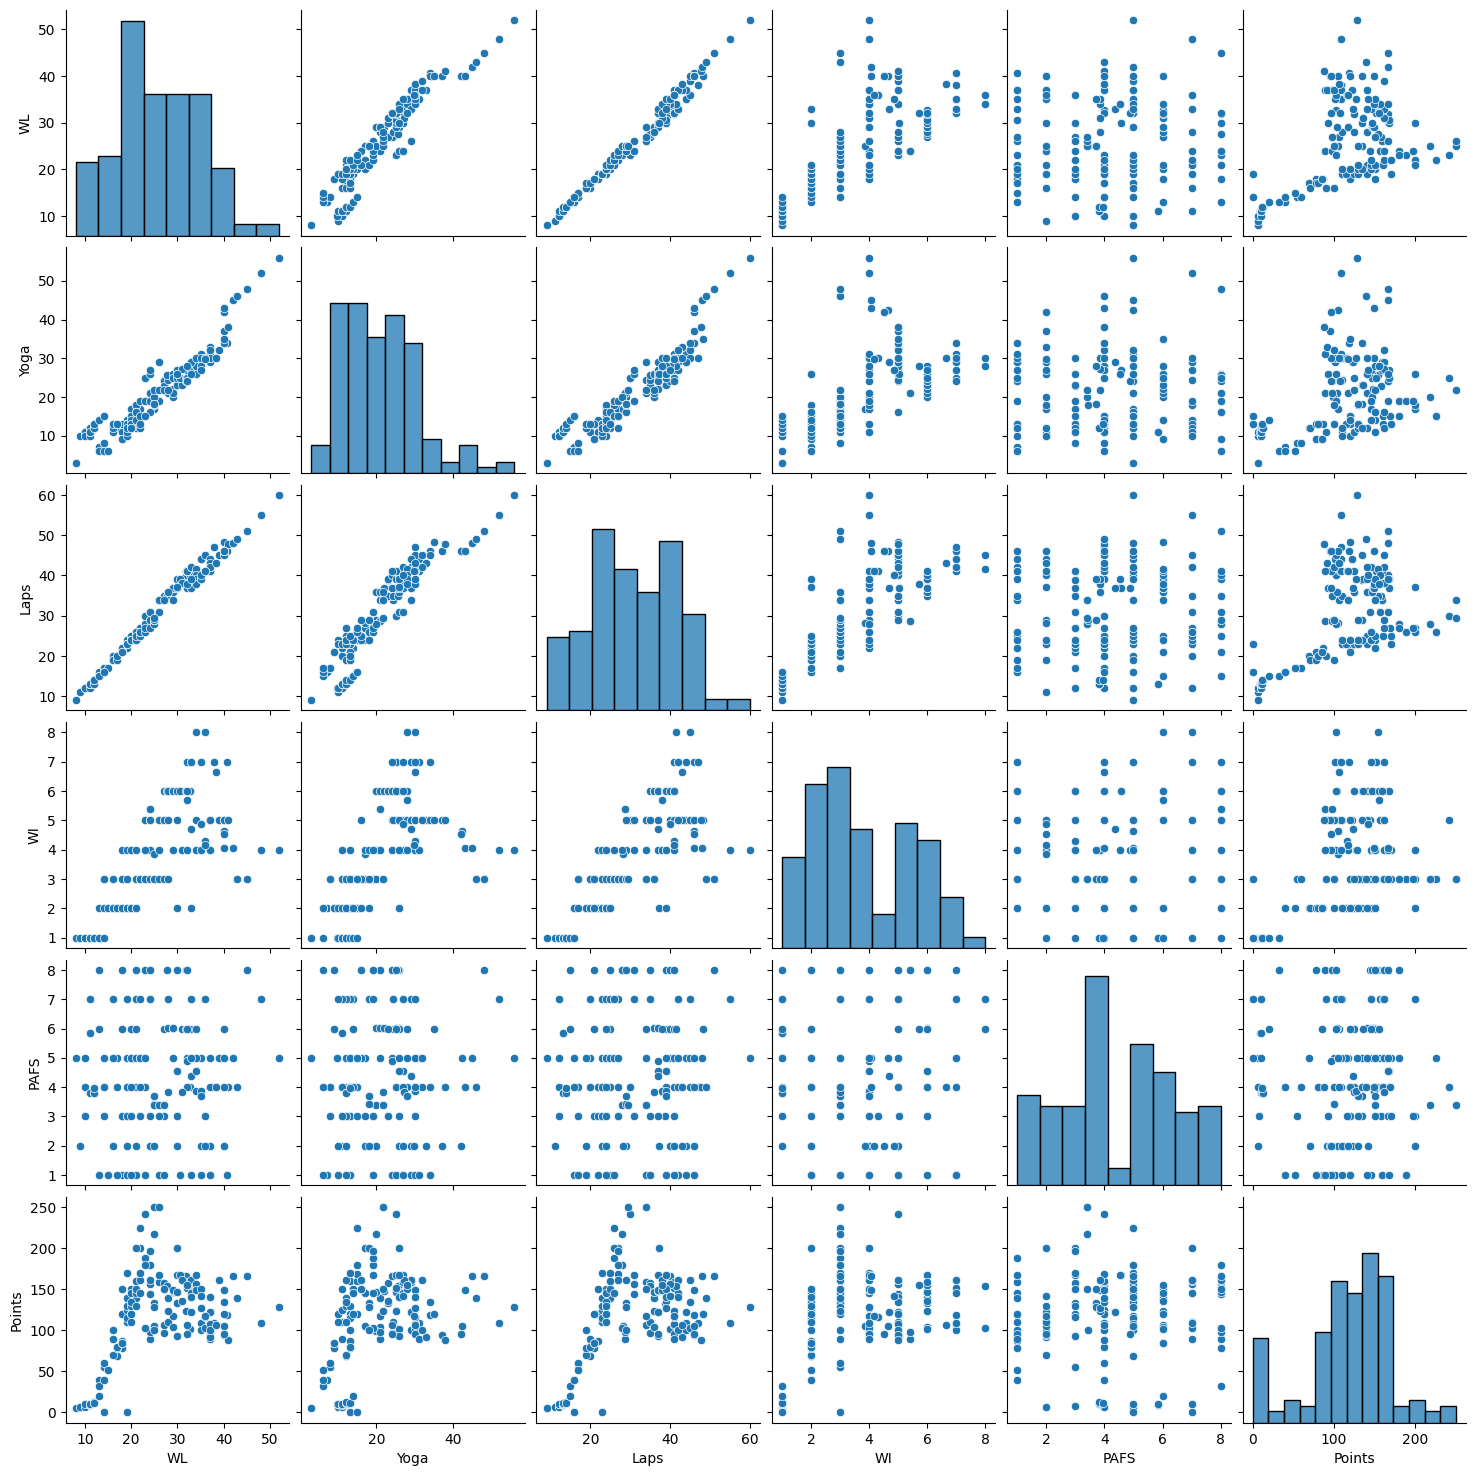

In [66]:
# scatter pairplot
sns.pairplot(df_new, kind='scatter')

**Chatterjee Correlation**    
Chatterjee correlation is a coefficient of correlation proposed by Sourav Chatterjee that measure the degree of dependence between two random variables without assuming anything about their distributions. It is a simple and interpretable measure of dependence that ranges between 0 and 1, where 0 indicate independence and 1 indicates that one variable is a measurable function of the other.    

Compared to other correlation coefficients, the Chatterjee correlation is less sensitive to outliers and non-linear relationships between variables. However, it requires more computational resources due to its non-parametric nature.    

The calculation involves the following steps:    
* Rank the Y values in the dataset, assigning the smallest value the rank of 1, the second smallest to rank of 2, and so on. Store these ranks in a new column called 'rank'.     
* Rank the X values in the dataset, in similar order, and store these ranks in a new column 'rank_x'.    
* Sort the dataset in increasing order of rank_x.    
* Calculate the absolute difference between the ranks of Y for consecutive X values. Sum up these differences.    
* Calculate the Chatterjee correlation coefficient using the formula:    
   Chatterjee correlation coefficient = 1 - 3 *(summ of absolute differences in ranks) / (N^2 -1), where N is the number of observations in the datset.     


In [67]:
# function to find Chatterjee correlation coefficient
def chatterjee_corr(df, x, y):
    N = df.shape[0]
    df_rank = df

    df_rank['rank'] = df_rank[y].rank()
    df_rank['rank_x'] = df_rank[x].rank()

    df_rank = df_rank.sort_values(by='rank_x')

    chatt_corr = 1 - (3 * df_rank['rank'].diff().abs().sum()) / (pow(N,2) - 1)

    return chatt_corr

In [68]:
chatterjee_corr(df_new, 'WL', 'Points')

0.4062872405999589

In [69]:
chatterjee_corr(df_new, 'WI', 'Points')

0.39198685021573865

In [70]:
chatterjee_corr(df_new, 'Laps', 'Points')

0.4229299363057325

In [71]:
chatterjee_corr(df_new, 'PAFS', 'Points')

0.0019930141771111742

In [72]:
chatterjee_corr(df_new, 'Yoga', 'Points')

0.2911444421614958

Determining whether Team essentially affects the Points variable for the dataset

**Single Way ANOVA**    
The null hypothesis for ANOVA is that all groups have the same mean, while the alternative hypothesis is that atleast one group has a different mean. The test calculates F values, which are the ratio of the between group mean squares and within groups mean squares, and p-values.     

The F value is used to determine whether or not the means of the groups are significantly different, while the p-value is used to determine the probability of obtaining a certain F value by chance.     

It is important to note that ANOVA only tells you that there is a difference between groups, but not where the difference is. 

In [73]:
import random

nba_id = list(df_new.index.unique())

random.seed(13)

sample_match_id = random.sample(nba_id, 50)

In [75]:
sample_df = df_new[df_new.index.isin(sample_match_id)].reset_index(drop=True)

sample_df.head()

,WL,Yoga,Laps,WI,PAFS,Points,Team,rank,rank_x
0,26.000000,29.000000,34.0,5.0,1.000000,159,Lakers,126.5,126.0
1,28.000000,24.366748,35.0,5.0,7.000000,110,Lakers,62.5,98.0
2,29.000000,25.000000,37.0,6.0,6.014168,149,Lakers,110.0,101.5
3,30.000000,25.000000,39.0,6.0,8.000000,147,Lakers,106.0,101.5
4,32.712197,28.000000,39.0,6.0,4.000000,155,Lakers,121.5,121.0


In [76]:
sample_df = sample_df[['Team', 'Points']]
groups = sample_df.groupby('Team').count().reset_index()

In [77]:
groups

,Team,Points
0,Bulls,5
1,Clippers,4
2,Lakers,14
3,Porcupines,3
4,Trailblazers,20
5,Warriors,4


In [79]:
## To check Normality
import scipy.stats as stats

unique_teams = sample_df['Team'].unique()
unique_teams

array(['Lakers', 'Clippers', 'Warriors', 'Trailblazers', 'Porcupines',
       'Bulls'], dtype=object)

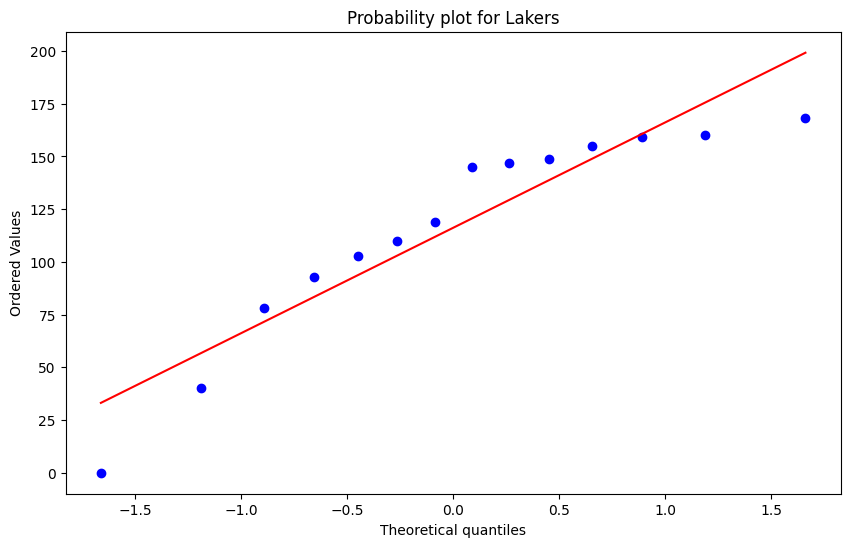

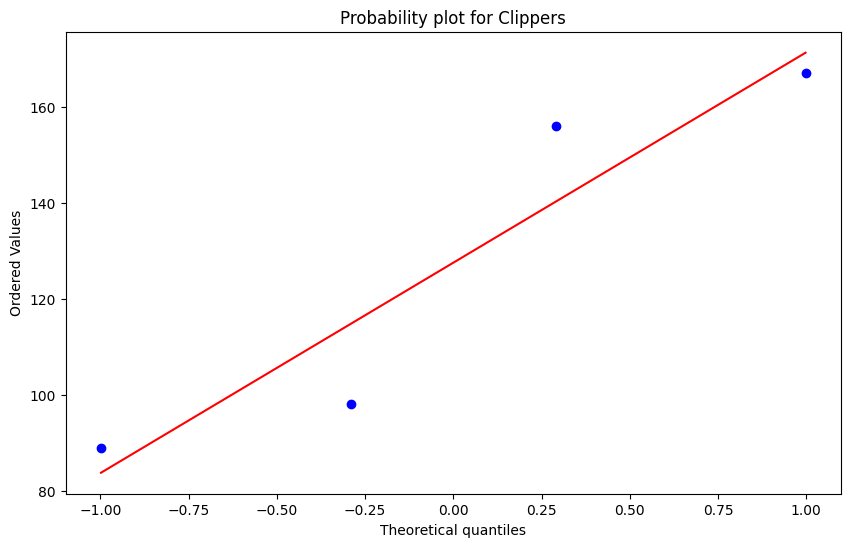

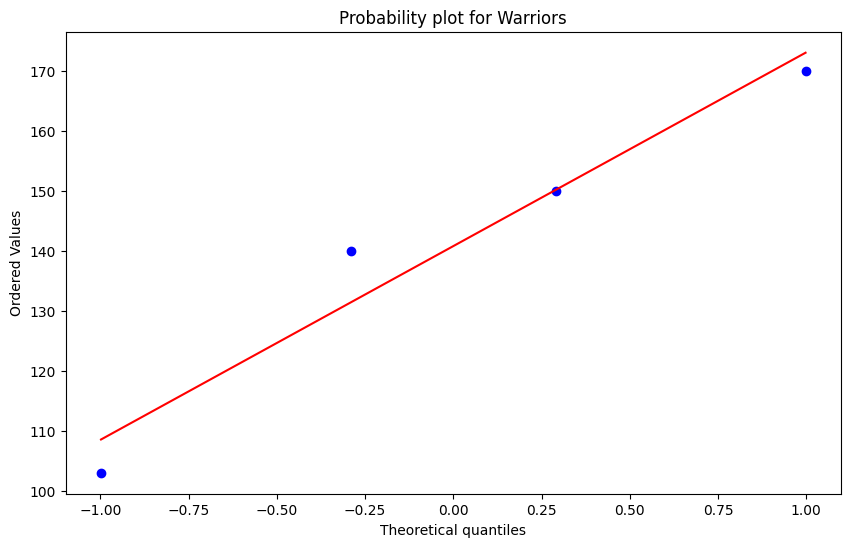

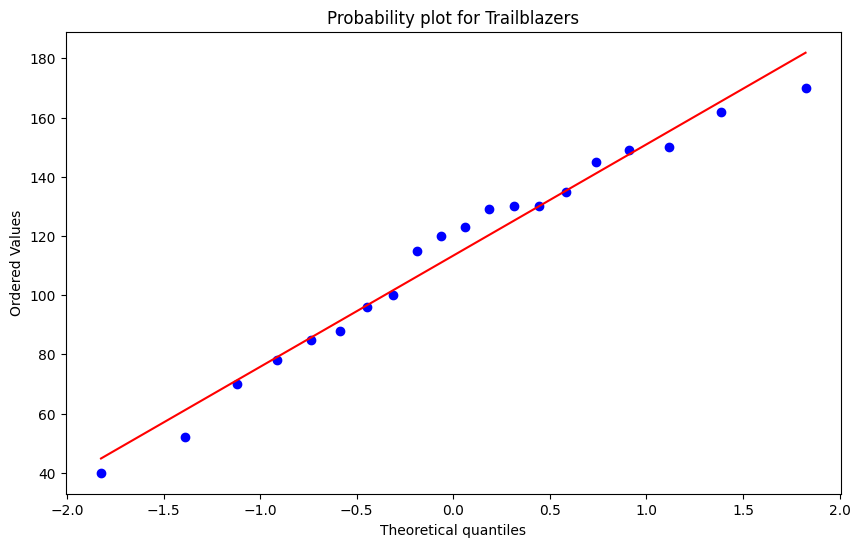

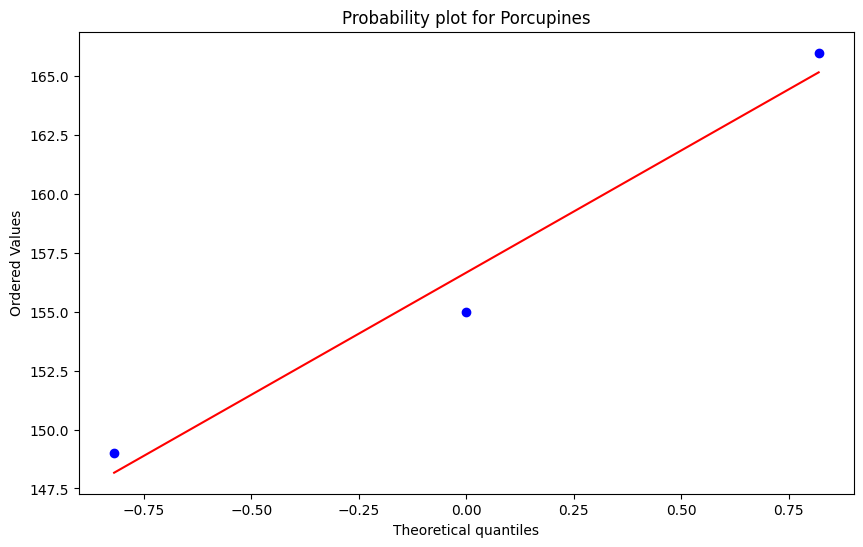

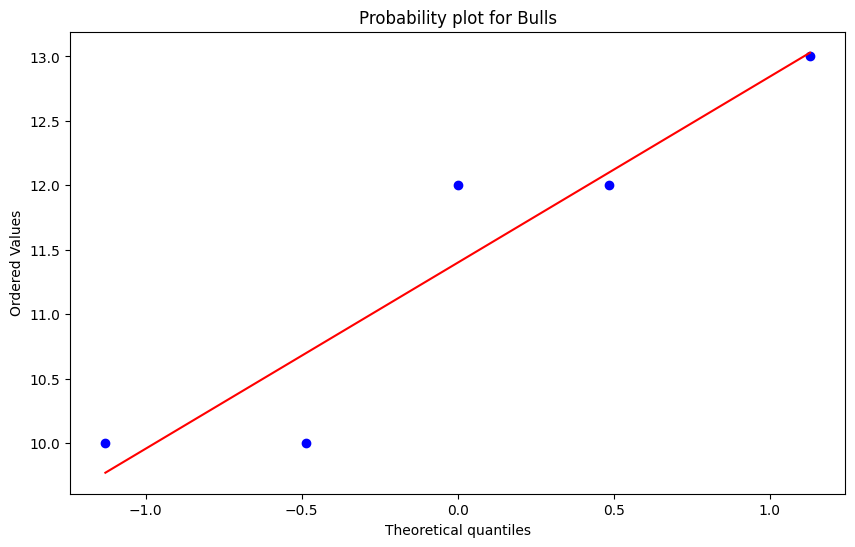

In [81]:
# quantile plots
for team in unique_teams:
    stats.probplot(sample_df[sample_df['Team'] == team]['Points'], dist='norm', plot=plt)
    plt.title('Probability plot for ' + team)
    plt.show()

In [82]:
ratio = sample_df.groupby('Team').std().max() / sample_df.groupby('Team').std().min()
ratio

Points    37.164289
dtype: float64

In [85]:
# implement ANOVA table
data = [['Between Groups', '','','','','',''], ['Within Groups', '','','','','',''], ['Total', '','','','','','']]

anova_table = pd.DataFrame(data, columns=['Variation', 'SS', 'df', 'MS', 'F-value', 'p-value', 'F-critical'])

anova_table.set_index('Variation', inplace=True)

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,,,,,,
Within Groups,,,,,,
Total,,,,,,


In [86]:
x_bar = sample_df['Points'].mean()

# Porcupines -2 overall 10 8
SSTR = sample_df.groupby('Team').count()*(sample_df.groupby('Team').mean() - x_bar)**2

In [87]:
anova_table['SS']['Between Groups'] = SSTR['Points'].sum()
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,,,,,,
Total,,,,,,


In [88]:
SSE = (sample_df.groupby('Team').count() - 1)*sample_df.groupby('Team').std()**2
SSE

,Points
Team,
Bulls,7.200000
Clippers,4725.000000
Lakers,32319.714286
Porcupines,148.666667
Trailblazers,24798.550000
Warriors,2366.750000


In [89]:
anova_table['SS']['Within Groups'] = SSE['Points'].sum()
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,64365.880952,,,,,
Total,,,,,,


In [91]:
total = SSE['Points'].sum() + SSTR['Points'].sum()
anova_table['SS']['Total'] = total
anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,,,,,
Within Groups,64365.880952,,,,,
Total,125268.02,,,,,


In [92]:
anova_table['df']['Between Groups'] = sample_df['Team'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['Team'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,,,,
Within Groups,64365.880952,44,,,,
Total,125268.02,49,,,,


In [95]:
anova_table['MS'] = anova_table['SS'] / anova_table['df']
anova_table['F-value']['Between Groups'] = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['p-value']['Between Groups'] = 1 - stats.f.cdf(anova_table['F-value']['Between Groups'], anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,12180.42781,8.326443,0.000013,
Within Groups,64365.880952,44,1462.860931,,,
Total,125268.02,49,2556.490204,,,


In [96]:
alpha = 0.05
hypothesis_type = 'two-tailed'

if hypothesis_type == 'two-tailed':
    alpha = alpha/2

anova_table['F-critical']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

anova_table

,SS,df,MS,F-value,p-value,F-critical
Variation,,,,,,
Between Groups,60902.139048,5,12180.42781,8.326443,0.000013,2.871184
Within Groups,64365.880952,44,1462.860931,,,
Total,125268.02,49,2556.490204,,,
